Data Collection from Twitter

In [ ]:
import time
import tweepy
import pandas as pd

# Authenticate (Replace with your actual keys)
client = tweepy.Client(bearer_token="AAAAAAAAAAAAAAAAAAAAAA1%2BzgEAAAAAmMjwePvGSh7YaljizYO3tbdNl0Q%3Dyytf5hkyE6oan8fQ9WiIflg9mrfzWRdw3ZywFXyCoO3wrEb08b")

query = "disaster relief -is:retweet lang:en"

# CSV file setup
csv_filename = "tweets.csv"

# Function to save tweets
def save_tweets(tweets):
    data = []

    for tweet in tweets.data:
        data.append([tweet.created_at, tweet.id, tweet.text])

    df = pd.DataFrame(data, columns=["Timestamp", "Tweet ID", "Tweet Text"])

    # Append to CSV (without overwriting)
    df.to_csv(csv_filename, mode="a", index=False, header=not pd.io.common.file_exists(csv_filename))
    print(f"Saved {len(df)} tweets to {csv_filename}")

# Fetch tweets at regular intervals
while True:
    try:
        tweets = client.search_recent_tweets(query=query, max_results=10, tweet_fields=["created_at"])

        if tweets.data:
            save_tweets(tweets)
        else:
            print("No new tweets found.")

        print("Waiting 5 minutes before next fetch...\n")
        time.sleep(300)

    except tweepy.TooManyRequests:
        print("Rate limit hit. Waiting for 15 minutes...")
        time.sleep(900)


Saved 10 tweets to tweets.csv
Waiting 5 minutes before next fetch...



KeyboardInterrupt: 

In [ ]:
import pandas as pd
import re

# Load tweets
df = pd.read_csv("tweets.csv")

# Basic text cleaning function
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)                 # Remove URLs
    text = re.sub(r"@\w+", "", text)                    # Remove mentions
    text = re.sub(r"#", "", text)                       # Remove hashtags
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)          # Remove special characters
    text = re.sub(r"\s+", " ", text)                    # Remove extra spaces
    text = text.lower()                                 # Convert to lowercase
    return text.strip()

df["Cleaned_Text"] = df["Tweet Text"].apply(clean_text)

# Save to new CSV
df.to_csv("cleaned_tweets.csv", index=False)
print("Preprocessing complete. Saved to 'cleaned_tweets.csv'")


Preprocessing complete. Saved to 'cleaned_tweets.csv'


In [ ]:
df = pd.read_csv("cleaned_tweets.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Timestamp     10 non-null     object
 1   Tweet ID      10 non-null     int64 
 2   Tweet Text    10 non-null     object
 3   Cleaned_Text  10 non-null     object
dtypes: int64(1), object(3)
memory usage: 452.0+ bytes


#✅ Step 3: Sentiment & Emotion Classification

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load cleaned tweets
df = pd.read_csv("cleaned_tweets.csv")

# Load sentiment model & tokenizer
sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Load emotion model
emotion_model = pipeline("text-classification", model="nateraw/bert-base-uncased-emotion", return_all_scores=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Apply sentiment analysis
df["Sentiment"] = df["Cleaned_Text"].apply(lambda x: sentiment_model(x)[0]['label'])

# Apply emotion classification
# Access the 'label' from the first element of the list returned by emotion_model
df["Emotion"] = df["Cleaned_Text"].apply(lambda x: emotion_model(x)[0]['label'])

# Save results
df.to_csv("analyzed_tweets.csv", index=False)
print("Sentiment and emotion classification done. Saved to 'analyzed_tweets.csv'")

Sentiment and emotion classification done. Saved to 'analyzed_tweets.csv'


In [ ]:
df = pd.read_csv("analyzed_tweets.csv")
df.head()

,Timestamp,Tweet ID,Tweet Text,Cleaned_Text,Sentiment,Emotion
0,2025-04-15 17:55:51+00:00,1912203227572941197,@GovBraun I am declaring a disaster emergency ...,i am declaring a disaster emergency for govern...,LABEL_0,joy
1,2025-04-15 17:54:14+00:00,1912202820427882848,Review also this comment: https://t.co/xoTqyJvrD9,review also this comment,LABEL_1,anger
2,2025-04-15 17:53:49+00:00,1912202717013090555,The Seattle Times @seattletimes 21h\nThe Feder...,the seattle times 21h the federal emergency ma...,LABEL_1,anger
3,2025-04-15 17:49:20+00:00,1912201587620970556,@RapidResponse47 @PressSec No federal funding ...,no federal funding should be to any university...,LABEL_1,sadness
4,2025-04-15 17:47:38+00:00,1912201160217542766,And this is just one reason why NO FEDERAL FUN...,and this is just one reason why no federal fun...,LABEL_0,anger


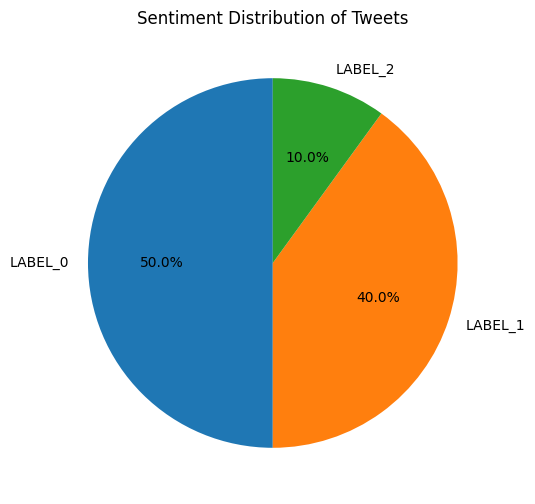

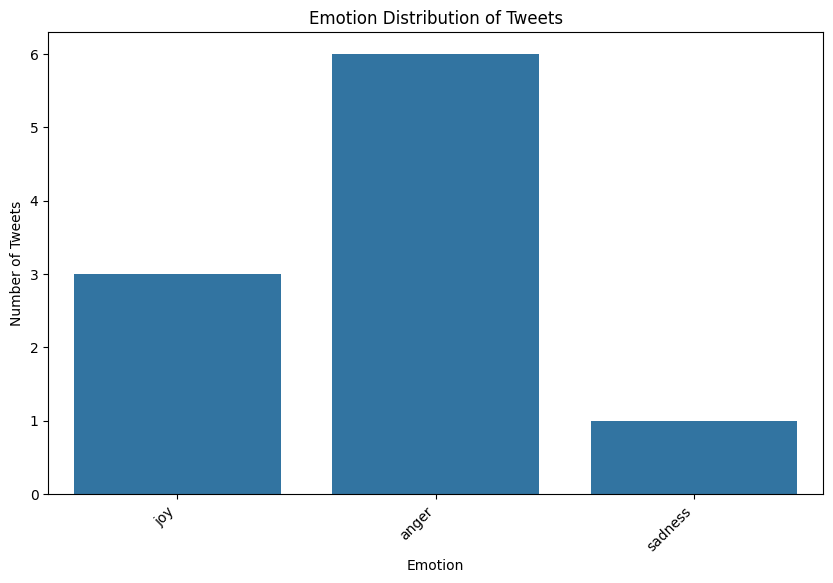

In [ ]:
# prompt: Make a pie chart or bar graph for Sentiment: Positive / Neutral / Negative
# Emotion: Joy / Anger / Sadness / etc.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the analyzed tweets data
df = pd.read_csv("analyzed_tweets.csv")

# Sentiment Analysis Visualization
plt.figure(figsize=(8, 6))
sentiment_counts = df['Sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution of Tweets')
plt.show()

# Emotion Analysis Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='Emotion', data=df)
plt.title('Emotion Distribution of Tweets')
plt.xlabel('Emotion')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Timestamp     10 non-null     object
 1   Tweet ID      10 non-null     int64 
 2   Tweet Text    10 non-null     object
 3   Cleaned_Text  10 non-null     object
 4   Sentiment     10 non-null     object
 5   Emotion       10 non-null     object
dtypes: int64(1), object(5)
memory usage: 612.0+ bytes


#🔥 Step 4: Urgency Detection using Zero-Shot Classification

In [ ]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
candidate_labels = ["urgent", "informational", "misinformation", "irrelevant"]


In [ ]:
def classify_urgency(text):
    result = classifier(text, candidate_labels)
    return result['labels'][0]  # Take top label

df["Urgency_Label"] = df["Cleaned_Text"].apply(classify_urgency)


In [ ]:
df.to_csv("final_tweets_classified.csv", index=False)
print("Urgency classification complete. Saved to 'final_tweets_classified.csv'")


Urgency classification complete. Saved to 'final_tweets_classified.csv'


In [ ]:
df = pd.read_csv("final_tweets_classified.csv")
df.head()

,Timestamp,Tweet ID,Tweet Text,Cleaned_Text,Sentiment,Emotion,Urgency_Label
0,2025-04-15 17:55:51+00:00,1912203227572941197,@GovBraun I am declaring a disaster emergency ...,i am declaring a disaster emergency for govern...,LABEL_0,joy,urgent
1,2025-04-15 17:54:14+00:00,1912202820427882848,Review also this comment: https://t.co/xoTqyJvrD9,review also this comment,LABEL_1,anger,informational
2,2025-04-15 17:53:49+00:00,1912202717013090555,The Seattle Times @seattletimes 21h\nThe Feder...,the seattle times 21h the federal emergency ma...,LABEL_1,anger,urgent
3,2025-04-15 17:49:20+00:00,1912201587620970556,@RapidResponse47 @PressSec No federal funding ...,no federal funding should be to any university...,LABEL_1,sadness,informational
4,2025-04-15 17:47:38+00:00,1912201160217542766,And this is just one reason why NO FEDERAL FUN...,and this is just one reason why no federal fun...,LABEL_0,anger,misinformation


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd

st.set_page_config(layout="wide")
st.title("🌍 Real-Time Disaster Tweet Monitoring Dashboard")

@st.cache_data(ttl=60)
def load_data():
    df = pd.read_csv("final_tweets_classified.csv")
    return df

df = load_data()

col1, col2 = st.columns(2)

with col1:
    st.subheader("📈 Sentiment Distribution")
    sentiment_count = df['Sentiment'].value_counts()
    st.bar_chart(sentiment_count)

with col2:
    st.subheader("😶 Emotion Distribution")
    emotion_count = df['Emotion'].value_counts()
    st.bar_chart(emotion_count)

st.subheader("🚨 Urgency Classification")
urgency_count = df['Urgency_Label'].value_counts()
st.bar_chart(urgency_count)

st.subheader("🔍 Sample Classified Tweets")
st.dataframe(df[['Tweet Text', 'Sentiment', 'Emotion', 'Urgency_Label']].head(10))


Writing app.py


In [ ]:
!ngrok config add-authtoken 2vg6TKE6mK8PjXNKLTreD8Gax3t_3zyEMYGmKnmFJnrSNyhkG


/bin/bash: line 1: ngrok: command not found


In [ ]:
from pyngrok import ngrok
import threading
import time

# Start the Streamlit app in a separate thread
def run():
    !streamlit run app.py &> logs.txt

thread = threading.Thread(target=run)
thread.start()
time.sleep(5)  # Wait for streamlit to spin up

# Open the public URL using ngrok
url = ngrok.connect(8501)
print("Streamlit app is live at:", url)


ModuleNotFoundError: No module named 'pyngrok'

Validation steps for:

Sentiment

Emotion

Urgency

In [ ]:

manual_labels = {
    1911415120518848659: ('LABEL_1', 'joy', 'informational'),    # Positive, hopeful relief, sharing info
    1911414915434237964: ('LABEL_1', 'joy', 'urgent'),           # Positive, hopeful relief, urgent tone
    1911414810266292620: ('LABEL_0', 'anger', 'informational'),  # Negative, denied relief, sharing news
    1911414690908864816: ('LABEL_1', 'joy', 'urgent'),           # Positive, hopeful relief, urgent tone
    1911414444631957835: ('LABEL_1', 'joy', 'informational'),    # Positive, hopeful relief, sharing info
    1911413975780110636: ('LABEL_1', 'joy', 'informational'),    # Positive, factual about FEMA, neutral joy
    1911413867676106767: ('LABEL_0', 'anger', 'informational'),  # Negative, angry accusations
    1911413830522974485: ('LABEL_1', 'joy', 'informational'),    # Positive, hopeful relief
    1911413443917132003: ('LABEL_0', 'anger', 'informational'),  # Negative, angry about ignored message
    1911413217152106578: ('LABEL_1', 'joy', 'informational'),    # Positive, hopeful relief
    1911451307468357738: ('LABEL_1', 'joy', 'informational'),    # Positive, proud of RSS efforts
    1911450778855735502: ('LABEL_0', 'anger', 'informational'),  # Negative, defensive and critical
    1911447273680085474: ('LABEL_0', 'anger', 'informational'),  # Negative, confrontational challenge
    1911446655120867634: ('LABEL_0', 'sadness', 'informational'),# Negative, clarifying relief source
    1911446202777747564: ('LABEL_1', 'joy', 'informational'),    # Positive, optimistic about AI
    1911445185487155410: ('LABEL_0', 'anger', 'urgent'),         # Negative, mocking denial of relief
    1911444903516602879: ('LABEL_0', 'sadness', 'urgent'),       # Negative, personal distress
    1911444543569871294: ('LABEL_1', 'joy', 'informational'),    # Positive, questioning funds positively
    1911440425430167745: ('LABEL_0', 'anger', 'informational'),  # Negative, critical of denial
    1911456421117374810: ('LABEL_0', 'anger', 'urgent'),         # Negative, urgent about denied relief
    1911456400179339717: ('LABEL_0', 'anger', 'informational'),  # Negative, critical of policy
    1911455280879055353: ('LABEL_0', 'anger', 'informational'),  # Negative, critical of policy
    1911455124423160248: ('LABEL_0', 'anger', 'informational'),  # Negative, correcting misconception
    1911454606279815383: ('LABEL_0', 'anger', 'informational'),  # Negative, critical of policy
    1911454368395591853: ('LABEL_0', 'anger', 'informational'),  # Negative, debunking conspiracy
    1911461133183000651: ('LABEL_0', 'sadness', 'urgent'),       # Negative, urgent tech failure
    1911460770510229767: ('LABEL_0', 'anger', 'informational'),  # Negative, angry defense
    1911460523549286636: ('LABEL_0', 'anger', 'informational'),  # Negative, sarcastic critique
    1911466915693764938: ('LABEL_1', 'sadness', 'urgent'),       # Positive, offering relief, sad context
    1911466234723311800: ('LABEL_0', 'anger', 'misinformation'), # Negative, angry conspiracy
    1911466014547603960: ('LABEL_0', 'sadness', 'informational'),# Negative, observational, neutral sadness
    1911465530445451376: ('LABEL_0', 'anger', 'informational'),  # Negative, critical of unit
    1911465460383523115: ('LABEL_0', 'anger', 'informational'),  # Negative, critical of inaction
    1911465161883267478: ('LABEL_0', 'anger', 'informational'),  # Negative, critical priorities
    1911465144770760866: ('LABEL_1', 'joy', 'informational'),    # Positive, listing welfare services
    1911464640824893520: ('LABEL_1', 'sadness', 'urgent'),       # Positive, urgent call to help, sad context
    1911462675898589404: ('LABEL_1', 'joy', 'informational'),    # Positive, clarifying FEMA policy
    1911462540728586708: ('LABEL_0', 'sadness', 'informational'),# Negative, questioning relevance
}

df["True_Sentiment"] = df["Tweet ID"].map(lambda x: manual_labels.get(x, (None, None, None))[0])
df["True_Emotion"] = df["Tweet ID"].map(lambda x: manual_labels.get(x, (None, None, None))[1])
df["True_Urgency_Label"] = df["Tweet ID"].map(lambda x: manual_labels.get(x, (None, None, None))[2])

df_eval = df.dropna(subset=["True_Sentiment", "True_Emotion", "True_Urgency_Label"])

df_eval[["Tweet ID", "Sentiment", "True_Sentiment", "Emotion", "True_Emotion", "Urgency_Label", "True_Urgency_Label"]].head()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(
    df_eval["True_Sentiment"],
    df_eval["Sentiment"],
    labels=["LABEL_0", "LABEL_1"],
    title="Sentiment"
)

emotion_labels = sorted(df_eval["True_Emotion"].dropna().unique().tolist())
plot_confusion_matrix(
    df_eval["True_Emotion"],
    df_eval["Emotion"],
    labels=emotion_labels,
    title="Emotion"
)

urgency_labels = sorted(df_eval["True_Urgency_Label"].dropna().unique().tolist())
plot_confusion_matrix(
    df_eval["True_Urgency_Label"],
    df_eval["Urgency_Label"],
    labels=urgency_labels,
    title="Urgency Label"
)


In [ ]:
!pip install flask-ngrok transformers


In [ ]:
# Replace YOUR_AUTHTOKEN below with your own ngrok token
!./ngrok authtoken 2vinwMFJRzrJWrtM1aIFker41Qo_3poE11V7v2SBtPQnv9nym


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from flask import Flask, request, jsonify
from threading import Thread
from transformers import pipeline

app = Flask(__name__)

# Load model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
categories = ["Distress", "Informational", "Misinformation"]

@app.route('/')
def home():
    return "Tweet Classifier API is live!"

@app.route('/classify', methods=['POST'])
def classify():
    data = request.get_json()
    tweet = data.get("text")

    if not tweet:
        return jsonify({"error": "No tweet text provided"}), 400

    result = classifier(tweet, categories)
    return jsonify({
        "label": result["labels"][0],
        "confidence": round(result["scores"][0], 3)
    })

def run():
    app.run(host='0.0.0.0', port=5000)

# Start Flask in background thread
Thread(target=run).start()


Device set to use cpu


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000


In [ ]:
!pip install pyngrok

In [ ]:
import os
import time
from pyngrok import ngrok

# Start ngrok tunnel
public_url = ngrok.connect(5000)
print("🚀 Public URL:", public_url)


🚀 Public URL: NgrokTunnel: "https://e45e-34-150-215-250.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "facebook/bart-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer.save_pretrained("my_model")
model.save_pretrained("my_model")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
import shutil

shutil.make_archive("my_model", 'zip', "my_model")


'/content/my_model.zip'

In [ ]:
from google.colab import files
files.download("my_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>